In [119]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report
from sklearn.preprocessing import LabelEncoder
from xgboost import XGBClassifier
import xgboost as xgb
import pandas as pd
import matplotlib.pyplot as plt

### XGBoost with merchant information

In [120]:
# Load data
df_train = pd.read_parquet('train_df.parquet', engine='pyarrow')
df_test = pd.read_parquet('test_df.parquet', engine='pyarrow')

# Separate features X and target y (anomaly label 0 or 1)
X_train = df_train.drop('is_anomalous', axis=1)
y_train = df_train['is_anomalous']
X_test = df_test.drop('is_anomalous', axis=1)
y_test = df_test['is_anomalous']

In [121]:
# use label encoding for categorical/name columns (merchant info)
# label encoding is fine because tree-based models don’t assume ordering in the numbers

# Identify categorical columns
col_types = dict(X_train.dtypes)
label_cols = [col for col, dtype in col_types.items() if dtype == 'object']

# Label encode each categorical column (keeping consistency between train and test)
encoders = {}
for col in label_cols:
    encoder = LabelEncoder()
    combined = pd.concat([X_train[col], X_test[col]], axis=0).astype(str)
    encoder.fit(combined)
    X_train[col] = encoder.transform(X_train[col].astype(str))
    X_test[col] = encoder.transform(X_test[col].astype(str))
    encoders[col] = encoder  # Optional: store encoders for inverse_transform or future use

# remove datetime cols, only use important info (time between invoice date and due: invoice_age)
X_train = X_train.drop(columns=['invoice_date', 'due_date'])
X_test = X_test.drop(columns=['invoice_date', 'due_date'])

In [122]:
model_with_merchant_info = XGBClassifier(
    n_estimators=200,
    eval_metric='logloss',
    random_state=42
)

model_with_merchant_info.fit(X_train, y_train)

# Predict
y_pred = model_with_merchant_info.predict(X_test)

# Evaluation
print("Accuracy:", accuracy_score(y_test, y_pred))
print("\nClassification Report:\n", classification_report(y_test, y_pred))

Accuracy: 0.8821852731591449

Classification Report:
               precision    recall  f1-score   support

           0       0.84      0.97      0.90      1177
           1       0.96      0.77      0.85       928

    accuracy                           0.88      2105
   macro avg       0.90      0.87      0.88      2105
weighted avg       0.89      0.88      0.88      2105



### Model without merchant information

In [123]:
# Load data
df_train = pd.read_parquet('train_df.parquet', engine='pyarrow')
df_test = pd.read_parquet('test_df.parquet', engine='pyarrow')

# Separate features X and target y (anomaly label 0 or 1)
X_train = df_train.drop('is_anomalous', axis=1)
y_train = df_train['is_anomalous']
X_test = df_test.drop('is_anomalous', axis=1)
y_test = df_test['is_anomalous']

In [124]:
# use label encoding for categorical/name columns (po_number, payment_method, country, state, and currency)
# label encoding is fine because tree-based models don’t assume ordering in the numbers

# remove merchant, merchant chain, merchant branch, and merchant address
# remove datetime cols, only use important info (time between invoice date and due: invoice_age)
X_train = X_train.drop(columns=['merchant', 'merchant_branch', 'merchant_chain', 'merchant_address', 'invoice_date', 'due_date'])
X_test = X_test.drop(columns=['merchant', 'merchant_branch', 'merchant_chain', 'merchant_address', 'invoice_date', 'due_date'])

# Identify categorical columns
col_types = dict(X_train.dtypes)
label_cols = [col for col, dtype in col_types.items() if dtype == 'object']

# Label encode each categorical column (keeping consistency between train and test)
encoders = {}
for col in label_cols:
    encoder = LabelEncoder()
    combined = pd.concat([X_train[col], X_test[col]], axis=0).astype(str)
    encoder.fit(combined)
    X_train[col] = encoder.transform(X_train[col].astype(str))
    X_test[col] = encoder.transform(X_test[col].astype(str))
    encoders[col] = encoder  # Optional: store encoders for inverse_transform or future use

In [125]:
model = XGBClassifier(
    n_estimators=200,
    eval_metric='logloss',
    random_state=42
)

model.fit(X_train, y_train)

# Predict
y_pred = model.predict(X_test)

# Evaluation
print("Accuracy:", accuracy_score(y_test, y_pred))
print("\nClassification Report:\n", classification_report(y_test, y_pred))

Accuracy: 0.8859857482185273

Classification Report:
               precision    recall  f1-score   support

           0       0.85      0.97      0.90      1177
           1       0.95      0.78      0.86       928

    accuracy                           0.89      2105
   macro avg       0.90      0.87      0.88      2105
weighted avg       0.89      0.89      0.88      2105



### Hyper-parameter tuning

In [126]:
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import make_scorer, recall_score

param_grid = {
    'n_estimators': [100, 200],
    'max_depth': [5, 6, 7, 8],
    'learning_rate': [0.01, 0.05, 0.1, 0.3],
    'subsample': [0.8, 1.0],
    'colsample_bytree': [0.8, 1.0]
}

# Define custom scorer
recall_1_scorer = make_scorer(recall_score, pos_label=1)

# Grid search
grid = GridSearchCV(
    estimator=XGBClassifier(random_state=42, eval_metric='logloss'),
    param_grid=param_grid,
    scoring=recall_1_scorer,
    cv=4
)

grid.fit(X_train, y_train)

print("Best Parameters:", grid.best_params_)
print("Best Recall for Class 1: {:.4f}".format(grid.best_score_))

Best Parameters: {'colsample_bytree': 1.0, 'learning_rate': 0.3, 'max_depth': 5, 'n_estimators': 200, 'subsample': 0.8}
Best Recall for Class 1: 0.7715


In [127]:
results_df = pd.DataFrame(grid.cv_results_)
display(results_df[['params', 'mean_test_score', 'rank_test_score']].sort_values(by='rank_test_score'))

,params,mean_test_score,rank_test_score
114,"{'colsample_bytree': 1.0, 'learning_rate': 0.3...",0.771464,1
115,"{'colsample_bytree': 1.0, 'learning_rate': 0.3...",0.771190,2
119,"{'colsample_bytree': 1.0, 'learning_rate': 0.3...",0.770918,3
50,"{'colsample_bytree': 0.8, 'learning_rate': 0.3...",0.770644,4
55,"{'colsample_bytree': 0.8, 'learning_rate': 0.3...",0.769551,5
...,...,...,...
67,"{'colsample_bytree': 1.0, 'learning_rate': 0.0...",0.715420,120
65,"{'colsample_bytree': 1.0, 'learning_rate': 0.0...",0.715420,120
64,"{'colsample_bytree': 1.0, 'learning_rate': 0.0...",0.715420,120
75,"{'colsample_bytree': 1.0, 'learning_rate': 0.0...",0.715420,120


In [128]:
# model for the best set of hyper-paramters

model = XGBClassifier(
    colsample_bytree=1.0,
    learning_rate=0.3,
    max_depth=5,
    subsample=0.8,
    n_estimators=200,
    eval_metric='logloss',
    random_state=42
)

model.fit(X_train, y_train)

# Predict
y_pred = model.predict(X_test)

# Evaluation
print("Accuracy:", accuracy_score(y_test, y_pred))
print("\nClassification Report:\n", classification_report(y_test, y_pred))

Accuracy: 0.8883610451306413

Classification Report:
               precision    recall  f1-score   support

           0       0.85      0.98      0.91      1177
           1       0.96      0.78      0.86       928

    accuracy                           0.89      2105
   macro avg       0.91      0.88      0.88      2105
weighted avg       0.90      0.89      0.89      2105



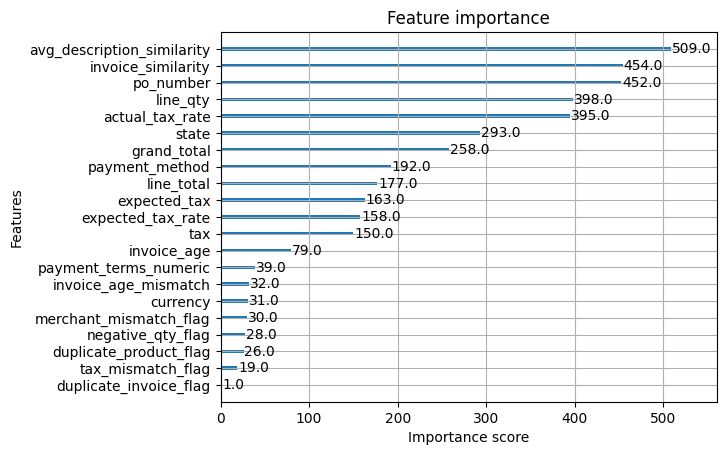

In [129]:
xgb.plot_importance(model)
plt.show()

### Threshold adjustment

In [130]:
# adjust the threshold for is_anomaly
y_proba = model.predict_proba(X_test)[:, 1]
y_pred_thresh = (y_proba >= 0.3).astype(int)  # lower threshold = higher recall

from sklearn.metrics import classification_report
print(classification_report(y_test, y_pred_thresh))

              precision    recall  f1-score   support

           0       0.86      0.91      0.89      1177
           1       0.88      0.81      0.85       928

    accuracy                           0.87      2105
   macro avg       0.87      0.86      0.87      2105
weighted avg       0.87      0.87      0.87      2105

